In [1]:
import os
import pickle
import subprocess

import matplotlib.cm as cm
import numpy as np
import open3d as o3d
import pandas as pd

from src.coloradar_tools import RadarParameters, get_heatmap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
COLORADAR_PATH = os.path.join(os.path.expanduser('~'), 'coloradar')
radar_params = RadarParameters(COLORADAR_PATH)

### Sensor Parameters

##### Lidar Sensor
- 0.01◦ angular accuracy; 
- angular resolution 0.35◦ horizontal,
- 0.7◦ vertical; 
- 3cm range accuracy; 
- field of view 360◦ horizontal,
- 45◦ vertical; 
- max range 120m;

#### Single Chip radar
- Range resolution 0.125m
- Max range 12m
- Doppler velocity resolution
- Max Doppler velocity
- Azimuth resolution 11.3◦
- Elevation resolution 45◦

### Show FOV options

In [6]:
radar_params.max_range

8.0

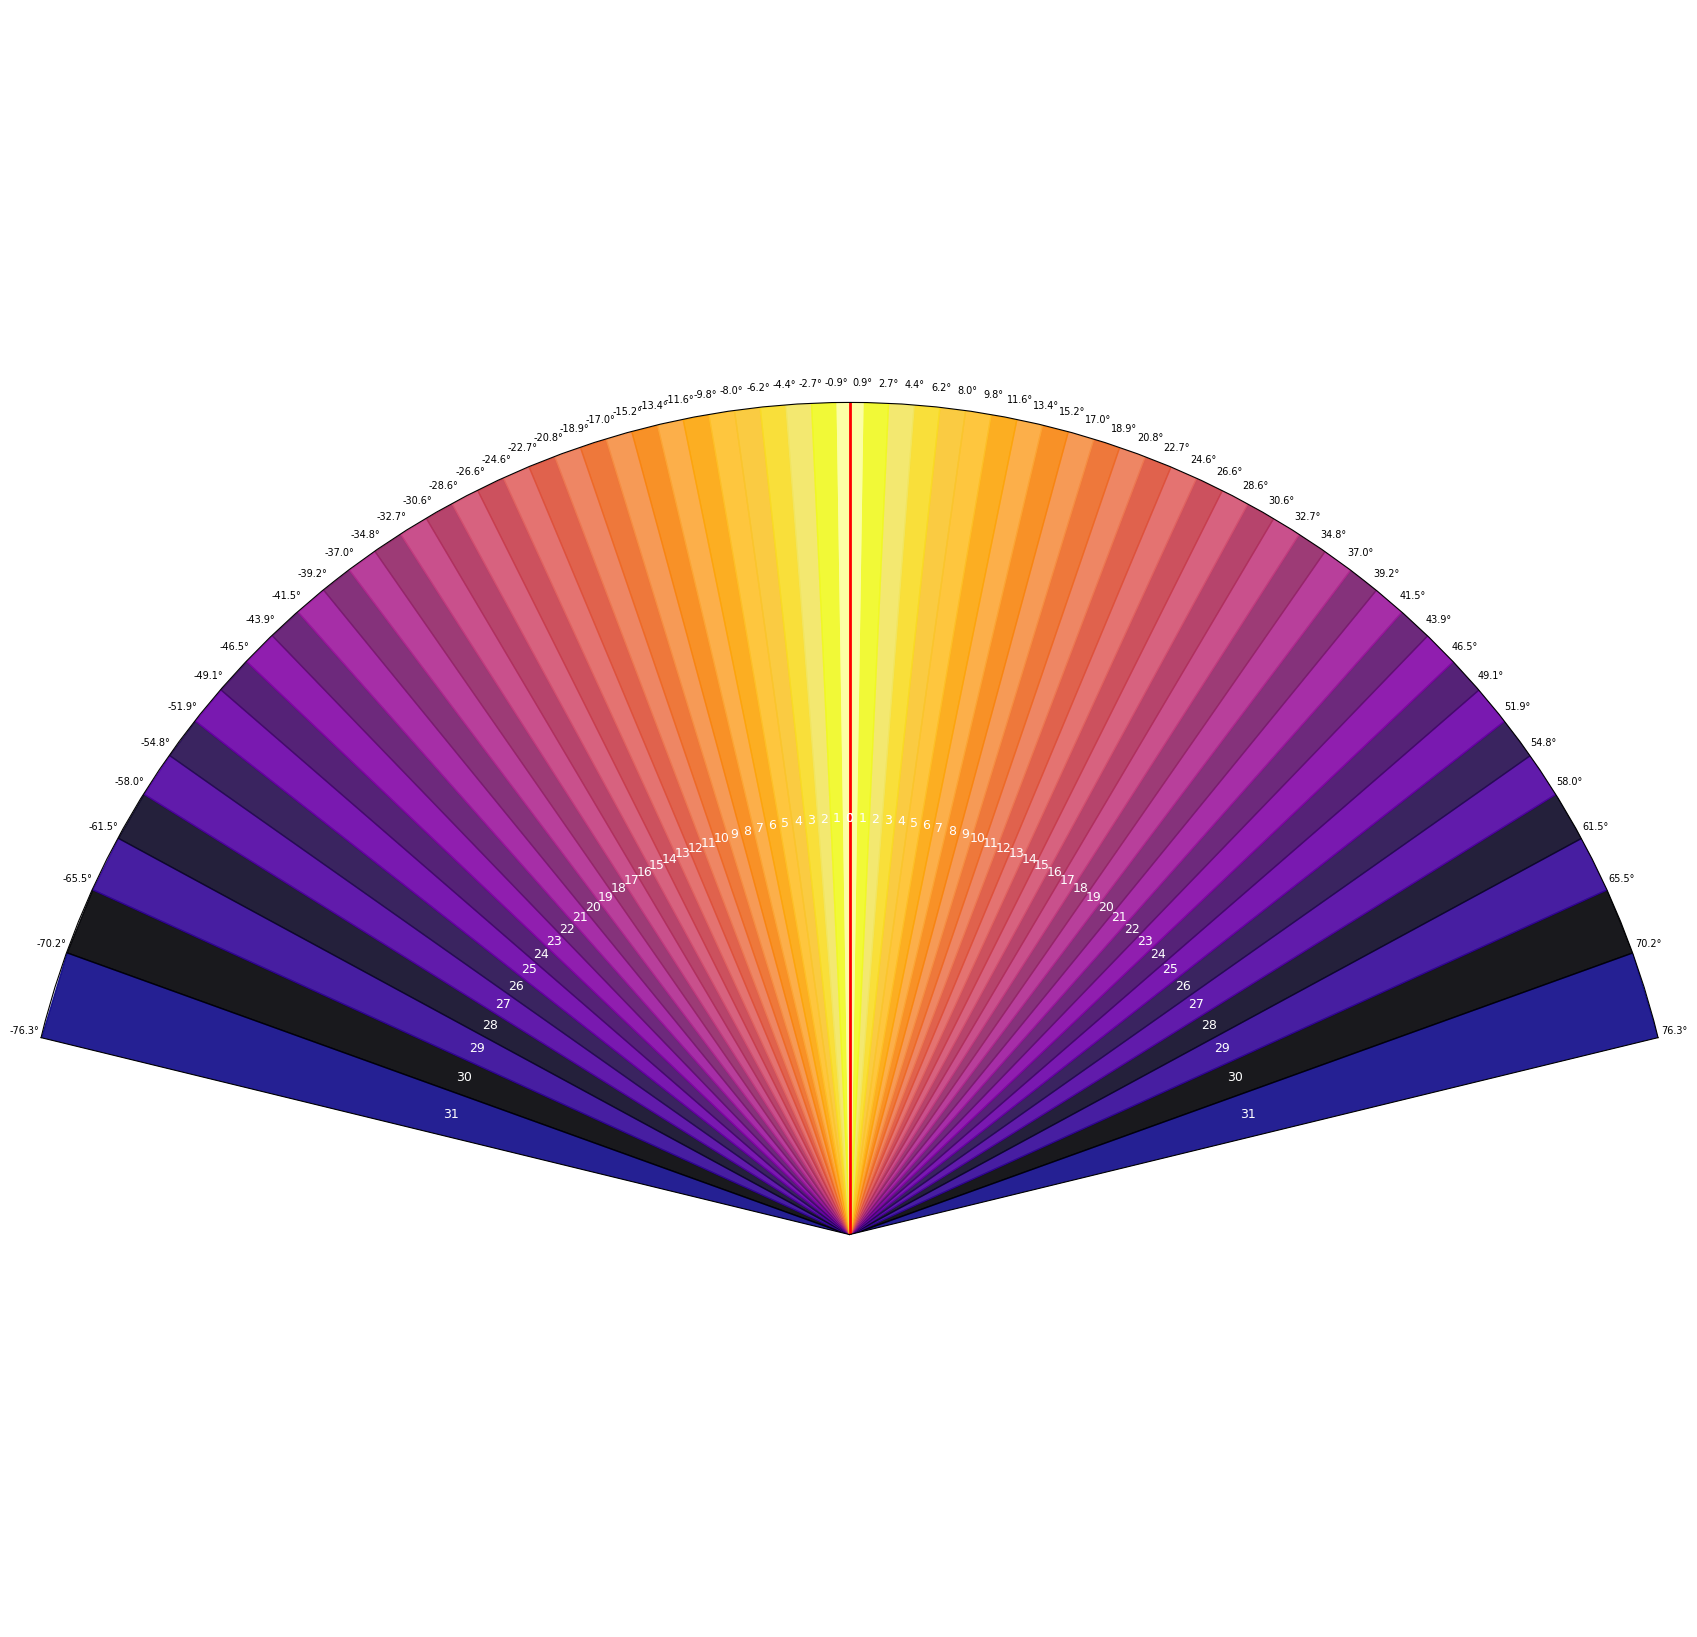

In [7]:
radar_params.display_azimuth_fov_options()

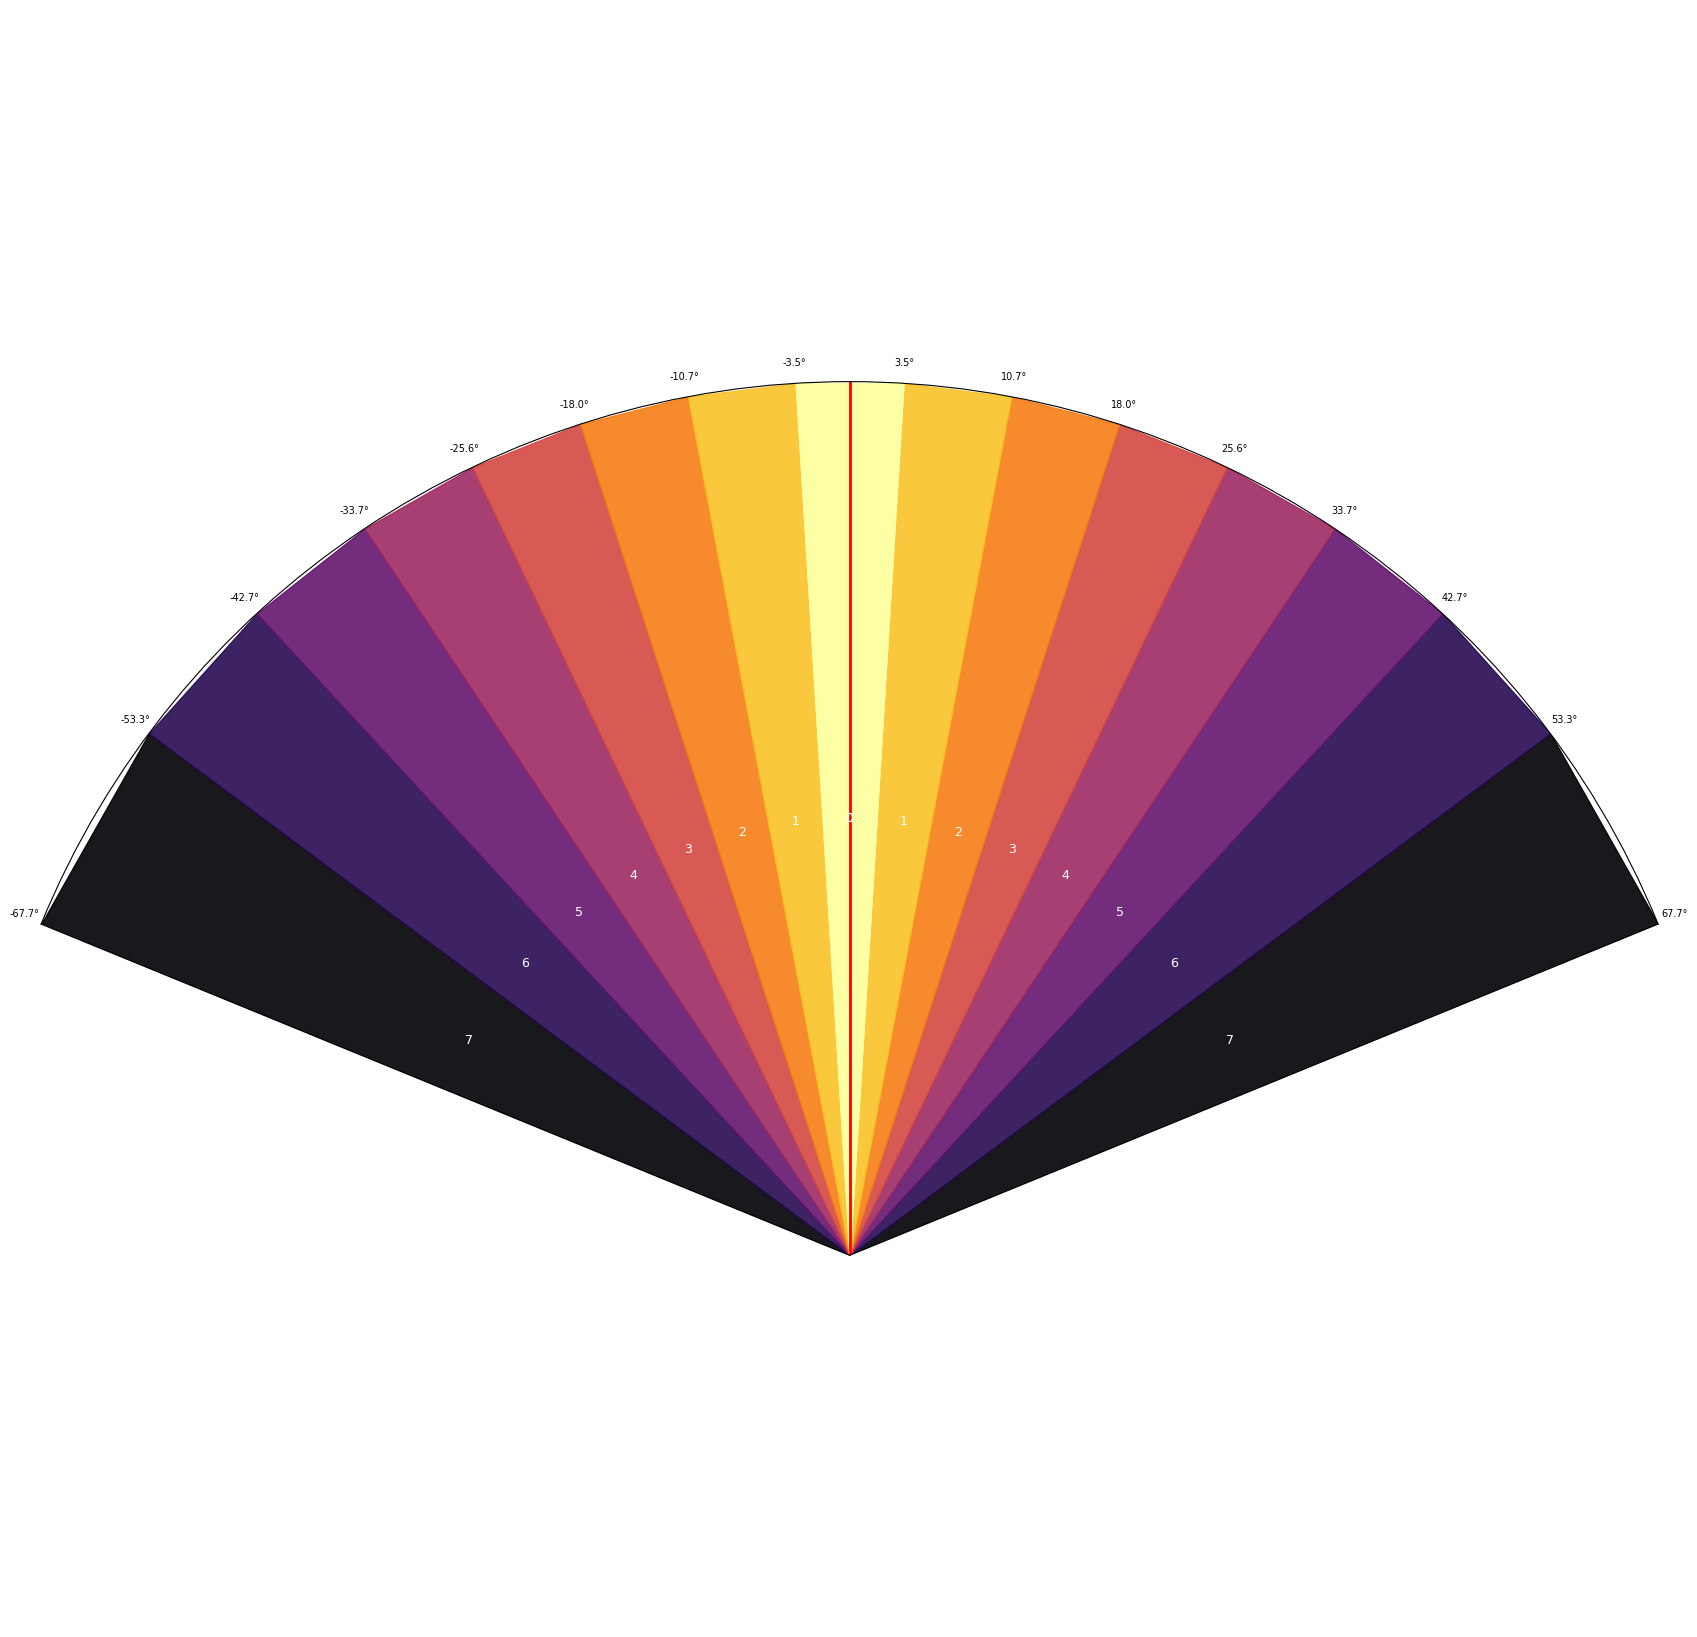

In [8]:
radar_params.display_elevation_fov_options()

### Create Octomap in FOV

In [173]:
params = display.get_fov_parameters(31, 7, 5)
command = [
    'ros2', 'run', 'mapless_navigation', 'octomap_node',
    '/home/arpg/coloradar/kitti/longboard_run0',
    f'horizontal_fov={params["horizontal_fov"]}',
    f'vertical_fov={params["vertical_fov"]}',
    f'range={params["range"]}'
]

In [174]:
result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(result.stdout)

FileNotFoundError: [Errno 2] No such file or directory: 'ros2'

In [148]:
csv_file_path = "/home/arpg/test_output/longboard_run0_octomap.csv"
df = pd.read_csv(csv_file_path)
points = df[['x', 'y', 'z']].values
probabilities = df['probability'].values

colormap = cm.get_cmap('jet')
colors = colormap(probabilities)[:, :3]  # Extract RGB, discard alpha

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

/tmp/ipykernel_834616/1352949174.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')


In [ ]:
o3d.visualization.draw_geometries([pcd])

In [ ]:
pcd_file_path = "/home/arpg/test_output/longboard_run0_octomap.pcd"
pcd = o3d.io.read_point_cloud(pcd_file_path)
points = np.asarray(pcd.points)

In [ ]:
points[0]

In [ ]:
def add_colors_based_on_probability(pcd, probabilities):
    colormap = cm.get_cmap('jet')
    colors = colormap(probabilities)[:, :3]  # Take only the RGB values, discard the alpha channel
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd


pcd_file_path = "/home/arpg/test_output/longboard_run0_octomap.pcd"
pcd = o3d.io.read_point_cloud(pcd_file_path)
points = np.asarray(pcd.points)
probabilities = np.array([point[3] for point in points])

colored_pcd = add_colors_based_on_probability(pcd, probabilities)

In [ ]:
o3d.visualization.draw_geometries([pcd])

In [ ]:
visualize_pcd(colored_pcd)

In [ ]:
# Set LD_LIBRARY_PATH to include the directory with liboctree_diff_lib.so
os.environ['LD_LIBRARY_PATH'] = "../../install/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

In [ ]:
# Run the test executable
!../../install/mapless_navigation/lib/mapless_navigation/test_octree_diff

In [ ]:
!ldd ../../install/mapless_navigation/lib/mapless_navigation/test_octree_diff

In [ ]:
ls ../../install/mapless_navigation/lib/

In [ ]:
coloradar_dir = '/home/arpg/coloradar'
calib_folder_name = 'calib'

In [ ]:
params = get_single_chip_params(calib_dir=os.path.join(coloradar_dir, calib_folder_name))

## Build Octomaps

In [ ]:
elevation_angle = 59  # from -29.5 to 29.5, max 76.3 * 2 degrees
azimuth_angle = 118  # from -59 to 59, max 79.8 * 2 degrees
y_max = 8
map_resolution = 0.25
# x_min, x_max = -5.68, 5.68
# x_max = int(y_max * np.tan(np.radians(azimuth_angle / 2)))
# z_max = int(y_max * np.tan(np.radians(elevation_angle / 2)))
x_max = y_max * np.tan(np.radians(azimuth_angle / 2)) // map_resolution * map_resolution
z_max = y_max * np.tan(np.radians(elevation_angle / 2)) // map_resolution * map_resolution
print('x_max', x_max, 'z_max', z_max)  # 13.25m, 4.5m
azimuth_from, azimuth_to = 4, 59  # from -59.68° to 59.68°
elevation_from, elevation_to = 4, 11  # from -38° to 38°
print('Azimuth indices:', azimuth_from, ':', azimuth_to)
print('Elevation indices:', elevation_from, ':', elevation_to)



params['x_min'], params['x_max'] = -x_max, x_max
params['y_min'], params['y_max'] = 0, y_max
params['z_min'], params['z_max'] = -z_max, z_max
params['azimuth_from'], params['azimuth_to'] = azimuth_from, azimuth_to
params['elevation_from'], params['elevation_to'] = elevation_from, elevation_to
data = {'params': params}

range_bin_width = round(params['heatmap']['range_bin_width'], 3)
range_bins = np.arange(range_bin_width, y_max + range_bin_width, range_bin_width)
azimuth_bins = parse_polar_bins(params['heatmap']['azimuth_bins'])[azimuth_from:azimuth_to + 1]
elevation_bins = parse_polar_bins(params['heatmap']['elevation_bins'])[elevation_from:elevation_to + 1]

for run_folder_name in ('ec_hallways_run1',
    'arpg_lab_run0',
    'aspen_run0', 'ec_hallways_run0', 'edgar_classroom_run0',
    'longboard_run0', 'outdoors_run0'
):
    print('Processing', run_folder_name)
    map_file_path = os.path.join(coloradar_dir, run_folder_name + '_lidar_octomap_points.csv')
    run_dir = os.path.join(coloradar_dir, run_folder_name)
    poses = np.loadtxt(os.path.join(run_dir, 'groundtruth/groundtruth_poses.txt'))
    pose_timestamps = np.loadtxt(os.path.join(run_dir, 'groundtruth/timestamps.txt'))
    heatmap_timestamps = np.loadtxt(os.path.join(run_dir, 'single_chip/heatmaps/timestamps.txt'))
    pose_indices = associate_radar_with_pose(heatmap_timestamps, pose_timestamps)
    map_points = np.loadtxt(map_file_path, delimiter=',', skiprows=1)
    # print(map_points.shape)
    # print(map_points[0])
    # print('Saving total map')
    # save_total_map(map_points, poses)

    print('Calculating frames')
    map_frames = []
    poses_matched, pose_timestamps_matched = [], []
    frame_grids = []
    heatmaps = []
    for heatmap_idx, pose_idx in tqdm(enumerate(pose_indices)):
        poses_matched.append(poses[pose_idx])
        pose_timestamps_matched.append(pose_timestamps[pose_idx])

        heatmap = get_heatmap(
            filename=os.path.join(run_dir, 'single_chip/heatmaps/data/heatmap_' + str(heatmap_idx) + '.bin'),
            params=params['heatmap']
        )[elevation_from:elevation_to + 1, azimuth_from:azimuth_to + 1, :, :]
        # print(calculate_heatmap_stats(heatmap))
        heatmaps.append(heatmap)
        if heatmap_idx % 10 == 0:
            save_heatmap_image(heatmap, filename=f'heatmap_small_{heatmap_idx}.png')

        # true_points = select_points_from_pose(map_points, x_max=x_max, y_max=y_max, z_max=z_max)
        localized_points = get_localized_pointcloud(
            poses[pose_idx], map_points,
            azimuth_angle=azimuth_angle,
            elevation_angle=elevation_angle,
            y_max=y_max, z_max=z_max, x_max=x_max
        )
        frame_grid = points_to_grid(
            localized_points, resolution=map_resolution,
            x_max=x_max, y_max=y_max, z_max=z_max,
            x_min=-x_max, y_min=0, z_min=-z_max
        )
        map_frames.append(localized_points)
        frame_grids.append(frame_grid)

    polar_grids = cartesian_to_polar_grid(
        np.array(frame_grids), x_min=-x_max, x_max=x_max, y_max=y_max, z_min=-z_max, z_max=z_max,
        azimuth_bins=azimuth_bins, elevation_bins=elevation_bins, range_bins=range_bins,
        range_bin_width=range_bin_width
    )
    data[run_folder_name] = {
        'heatmaps': heatmaps,
        'gt_grids': frame_grids,
        'polar_grids': polar_grids,
        'poses': poses_matched,
        'pose_timestamps': pose_timestamps_matched
        # 'gt_points': map_frames
    }
# visualize_true_frames(map_frames, x_max=x_max, y_max=y_max, z_max=z_max)
# return
print('Heatmap shape', heatmaps[0].shape)
# print('GT frame shape', localized_points.shape)
print('GT grid shape', frame_grid.shape)

if os.path.isfile(dataset_filename):
    with open(dataset_filename, 'rb') as f:
        data_old = pickle.load(f)
else:
    data_old = {}
data_old.update(data)
print('Writing runs:', data_old.keys())
with open(dataset_filename, 'wb') as f:
    pickle.dump(data_old, f)